In [1]:
from Peak_Search_Linien import LinienDevice
from windfreak import SynthHD
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from linien_utils import get_waveform, set_scan_range
from linien_client.connection import LinienClient
from scipy.signal import find_peaks

import statistics
import time
import tqdm
import csv
resource_name_windfreak = "COM8"
try:
    synthd = SynthHD(resource_name_windfreak)
    synthd.init()
except Exception as e:
    print(e)
rf_out = 1
c = LinienDevice(
    host="10.10.222.36",
    user="root",
    password="root"
)
# c.connect(autostart_server=True, use_parameter_cache=True)


linien_client.connection       INFO     Try to connect to 10.10.222.36:18862
linien_client.connection       INFO     Connection established!


Peak Search

In [2]:
for j in range(1,5):
    zero_amp_all = []
    fir_amp_all = []
    pow_max_all = []
    scan_data = []
    power_scan = np.linspace(-15, 10, 200)
    fre_scan = np.linspace(1700e6,2700e6,200)
    fre_scan = np.delete(fre_scan,np.where(np.logical_and(fre_scan<2000e6 , fre_scan>=1987e6))) # could not resolve
    fir_amps = []
    synthd[rf_out].enable = False
    time.sleep(1)
    c.ini_peak_search()
    synthd[rf_out].enable = True

    i=0
    i0=0
    while i < len(fre_scan):
        i0=i0+1
        if i0 > i + 20: # retried multiple times but couldnt find peak
            i0 = i
            np.delete(fre_scan, i)
            continue
        set_scan_range(c.client, 0, 0.6)    
        fre_scan_start = time.time()
        rf_fre = fre_scan[i]
        fir_amp = np.zeros(len(power_scan))
        synthd[rf_out].frequency = rf_fre
        if rf_out == 0:
            if rf_fre > 2300e6 and rf_fre > 2450e6:
                synthd[rf_out].power = -18
            elif rf_fre > 2450e6:
                synthd[rf_out].power = -14
            elif rf_fre > 1900e6 and rf_fre < 2000e6:
                synthd[rf_out].power = -25
            elif rf_fre >= 2050e6 and rf_fre <= 2100e6:
                synthd[rf_out].power = -25
            else:
                synthd[rf_out].power = -20
        else:
            if rf_fre < 1900e6:
                synthd[rf_out].power = -20
            else:
                synthd[rf_out].power = -25
        time.sleep(1)
        c.mod_peak_search(first_search=True)        
        c.zero_measure()
        if c.mod_zero_amp < 250:
            continue
        c.sweep_center = 0
        c.fir_measure(rf_fre, init_measure=True)
        if c.fir_amp < 10: # could not find peak
            # print("could not find peak")
            continue
        if c.fir_amp - c.mod_zero_amp > 0 or c.mod_zero_amp - c.fir_amp < 0.5*c.fir_amp: # found the 0th order peak
            continue
        
        avg = 1
        for _ in range(avg):
            for k in tqdm.tqdm(range(len(power_scan))):
                start = time.time()
                shdpower = power_scan[k]
                synthd[rf_out].power = shdpower
                c.fir_measure(rf_fre)
                fir_amp[k] = fir_amp[k] + c.fir_amp/avg    
        if max(fir_amp) < 25 and time.time() - fre_scan_start < 600: # probably did not find the right peak, refind
            continue
        if time.time() - fre_scan_start > 600: # still did not find the right peak, just find the peak without any zooming
            np.delete(fre_scan, i)
            continue
        pow_max = power_scan[np.where(fir_amp==max(fir_amp))[0]]    
        scan_data.append([rf_fre,pow_max])
        fir_amps.append(fir_amp)
        pow_max_all.append(pow_max)
        fir_amp_all.append(fir_amp)
        i=i+1
    
    import pickle
    with open(f'2024_4_3_NLTL4_powerscan_5MHzstep_fir_amp_all-{j}.pickle', 'wb') as handle:
        pickle.dump(fir_amp_all, handle, protocol=pickle.HIGHEST_PROTOCOL)      
    with open(f'2024_4_3_NLTL4_powerscan_5MHzstep_fre_scan-{j}.pickle', 'wb') as handle:
        pickle.dump(fre_scan, handle, protocol=pickle.HIGHEST_PROTOCOL)     
    with open(f'2024_4_3_NLTL4_powerscan_5MHzstep_pow_max-{j}.pickle', 'wb') as handle:
        pickle.dump(pow_max_all, handle, protocol=pickle.HIGHEST_PROTOCOL)     

 18%|█▊        | 35/200 [00:07<00:35,  4.68it/s]

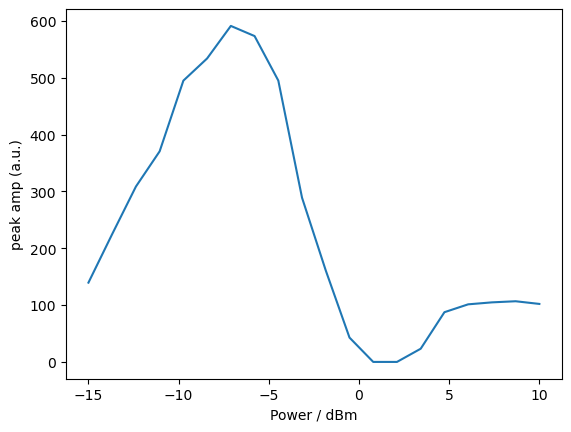

In [ ]:
from scipy.signal import savgol_filter as sf

for i in range(0, 1):
    plt.plot(power_scan,fir_amp_all[i],label = "first order")
    #plt.plot(power_scan,zero_amp_all[i],label = "zero order")
    plt.xlabel("Power / dBm")
    plt.ylabel("peak amp (a.u.)")

In [ ]:
plt.plot(fre_scan, pow_max_all)